# Quantitative Structure-Activity Relationships (QSAR)

Quantitative structure-activity relationship (QSAR) models are mathematical models that can be used to predict the physicochemical, biological and environmental fate properties of compounds from the knowledge of their chemical structure. The (Q)SAR has to be scientifically validated and provide sufficient documentation to allow an independent evaluation of the results.


*Steps to build a QSAR model:*

1) Data set compilation 

2) Data set processing 

3) Model Building 

4) Property prediction in target database

In [1]:
# Install required packages
# !pip install scikit-learn   # Python module for machine learning
# !pip install seaborn        # Statistical data visualization
# !pip install RDKit

# Import libraries
import json            
import requests        
import pandas as pd    
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, Draw, PandasTools
from rdkit.Chem import MACCSkeys, rdFingerprintGenerator
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn import metrics

## 1) Compile a Bioactivity Database

The first thing we have to do is to obtain a database of molecules with biological activity towards out query molecule. We will filter the results to obtain only assays measuring the half maximal inhibitory concentration (IC50). Moreover, we will only consider assays measuring inhibitory activity in nanomolar scale (nM) to facilitate comparison between IC50 values.

In [2]:
#Define activity_url.
BASE_URL = "https://www.ebi.ac.uk/chembl/api/data/{:s}"
activity_url = BASE_URL.format ("activity?target_chembl_id__exact=CHEMBL5145&offset=0&limit=0&standard_type__exact=IC50&standard_units__exact=nM")
activity_request = requests.get(activity_url, headers={"Accept":"application/json"}).json()['activities']

# Transform data in a table
activity_table = pd.DataFrame.from_dict(activity_request)[["molecule_chembl_id", "standard_value", "standard_units",
                                                           "standard_type", "type", "canonical_smiles"]]
print(len(activity_table), "assays found")
activity_table


1000 assays found


,molecule_chembl_id,standard_value,standard_units,standard_type,type,canonical_smiles
0,CHEMBL185238,16000.0,nM,IC50,IC50,Cc1cccc(-c2n[nH]cc2-c2ccc3ncccc3n2)n1
1,CHEMBL371694,900.0,nM,IC50,IC50,CC(C)(C)c1nc(-c2ccc(F)cc2)c(-c2ccncc2)[nH]1
2,CHEMBL200259,1585.0,nM,IC50,IC50,OCc1cccc(-c2[nH]c(-c3ccccc3)nc2-c2ccncc2)c1
3,CHEMBL68215,339.0,nM,IC50,IC50,Oc1ccc(-c2[nH]c(-c3ccccc3)nc2-c2ccncc2)cc1
4,CHEMBL200863,13.0,nM,IC50,IC50,CC(C)(CNC(=O)Nc1ccc(Cl)cc1)c1nc(-c2ccc(Cl)c(O)...
...,...,...,...,...,...,...
995,CHEMBL1214056,19.0,nM,IC50,IC50,CSc1cc(Oc2ccnc3[nH]c(=O)cnc23)ccc1NC(=O)Nc1cc(...
996,CHEMBL1214057,24.0,nM,IC50,IC50,CSc1cc(Oc2ccnc3[nH]c(=O)c(C)nc23)ccc1NC(=O)Nc1...
997,CHEMBL1214058,4.0,nM,IC50,IC50,Cc1nc2c(Oc3ccc(NC(=O)Nc4cc(C(F)(F)F)ccc4F)c4cc...
998,CHEMBL1214129,5.0,nM,IC50,IC50,Nc1nc2c(Oc3ccc(NC(=O)Nc4cc(C(F)(F)F)ccc4F)c4cc...


In [3]:
# Double check that the standard type / type of the assays is IC50
print(activity_table[['standard_type', 'type']].value_counts(),"\n")

# Rename the columns
activity_data = activity_table.drop(["standard_type", "type"], axis=1)
activity_data.rename(columns={'molecule_chembl_id': 'ChEMBLID','standard_value': 'IC50', 'standard_units': 'units', 'canonical_smiles': 'smiles'}, inplace=True)
activity_data.head()


standard_type  type 
IC50           IC50     995
               pIC50      5
dtype: int64 



,ChEMBLID,IC50,units,smiles
0,CHEMBL185238,16000.0,nM,Cc1cccc(-c2n[nH]cc2-c2ccc3ncccc3n2)n1
1,CHEMBL371694,900.0,nM,CC(C)(C)c1nc(-c2ccc(F)cc2)c(-c2ccncc2)[nH]1
2,CHEMBL200259,1585.0,nM,OCc1cccc(-c2[nH]c(-c3ccccc3)nc2-c2ccncc2)c1
3,CHEMBL68215,339.0,nM,Oc1ccc(-c2[nH]c(-c3ccccc3)nc2-c2ccncc2)cc1
4,CHEMBL200863,13.0,nM,CC(C)(CNC(=O)Nc1ccc(Cl)cc1)c1nc(-c2ccc(Cl)c(O)...


I realized that there is a large number of molecules within the bioactivity database with the same SMILES sequence, suggesting that some molecules are comformational isomers. We need to remove these conformers, I will group the molecules by their SMILES and, in case of conformational isomery, retain only the molecule with the lowest IC50.

In [4]:
activity_data = activity_data.groupby("smiles", as_index=False).min()
print(str(activity_data.shape[0]), "structurally different molecules")

768 structurally different molecules


In [5]:
# Order by IC50 value and drop rows with NaN values

activity_data['IC50'] = activity_data['IC50'].astype(float)
activity_data = activity_data.sort_values(by = 'IC50', ascending = True).dropna().reset_index(drop=True)
activity_data

,smiles,ChEMBLID,IC50,units
0,Cn1cc(-c2ccc3c(c2)CC/C3=N\O)c(-c2ccncc2)n1,CHEMBL500659,0.02,nM
1,O/N=C1\CCc2cc(-c3cn(C4CCNCC4)nc3-c3ccncc3)ccc21,CHEMBL526479,0.03,nM
2,O/N=C1\CCc2cc(-c3cn([C@@H]4CCC[C@H](O)C4)nc3-c...,CHEMBL498344,0.04,nM
3,OCCCn1cc(-c2ccc3c(c2)CC/C3=N\O)c(-c2ccncc2)n1,CHEMBL527029,0.05,nM
4,O/N=C1\CCc2cc(-c3cn([C@@H]4CCC[C@@H](O)C4)nc3-...,CHEMBL521562,0.09,nM
...,...,...,...,...
763,CC(=O)Nc1cccc(-c2cncc(NN(C)c3ccccc3)n2)c1,CHEMBL199805,100000.00,nM
764,COc1ccccc1N1C(=O)CC(N2CCC(C(N)=O)CC2)C1=O,CHEMBL459714,100000.00,nM
765,COc1cccc(N2C(=O)CC(N3CCN(Cc4ccccc4)CC3)C2=O)c1,CHEMBL462046,100000.00,nM
766,O=c1[nH]c2cccc(Oc3ccc(NS(=O)(=O)c4ccc(OC(F)(F)...,CHEMBL597399,100000.00,nM


In [6]:
# Save the results to a CSV file qsar_bioactivity_data.csv
activity_data.to_csv('./qsar_bioactivity_data_raw.csv', index=False)

## 2) Dataset Pre-processing 

Once we have filtered our bioactivity database, we need to preprocess the data for building the model. We will first obtain the Maccs and Morgan fingerprints of the bioactive molecules using RDKit library.

In [7]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str     The SMILES string defining the molecule.
    method : str     The type of fingerprint to use. Default is MACCS keys.
    n_bits : int     The length of the fingerprint.

    Returns
    -------
    array        The fingerprint array.
    """
 
    mol = Chem.MolFromSmiles(smiles)  # Convert smiles to RDKit mol object

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan":
        return np.array(rdFingerprintGenerator.GetFPs([mol]))[0]
    else:
        print(f"Warning: Wrong method specified: {method}." " Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [8]:
df = activity_data.copy()

df["maccs"] = activity_data["smiles"].apply(smiles_to_fp, method = "maccs")
df["morgan"] = activity_data["smiles"].apply(smiles_to_fp, method = "morgan")
df

,smiles,ChEMBLID,IC50,units,maccs,morgan
0,Cn1cc(-c2ccc3c(c2)CC/C3=N\O)c(-c2ccncc2)n1,CHEMBL500659,0.02,nM,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,O/N=C1\CCc2cc(-c3cn(C4CCNCC4)nc3-c3ccncc3)ccc21,CHEMBL526479,0.03,nM,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,O/N=C1\CCc2cc(-c3cn([C@@H]4CCC[C@H](O)C4)nc3-c...,CHEMBL498344,0.04,nM,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,OCCCn1cc(-c2ccc3c(c2)CC/C3=N\O)c(-c2ccncc2)n1,CHEMBL527029,0.05,nM,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,O/N=C1\CCc2cc(-c3cn([C@@H]4CCC[C@@H](O)C4)nc3-...,CHEMBL521562,0.09,nM,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
763,CC(=O)Nc1cccc(-c2cncc(NN(C)c3ccccc3)n2)c1,CHEMBL199805,100000.00,nM,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
764,COc1ccccc1N1C(=O)CC(N2CCC(C(N)=O)CC2)C1=O,CHEMBL459714,100000.00,nM,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
765,COc1cccc(N2C(=O)CC(N3CCN(Cc4ccccc4)CC3)C2=O)c1,CHEMBL462046,100000.00,nM,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
766,O=c1[nH]c2cccc(Oc3ccc(NS(=O)(=O)c4ccc(OC(F)(F)...,CHEMBL597399,100000.00,nM,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


We decided to use MACCS fingerprints instead of Morgan's to build our model. We extract the fingerprints of our molecule database and transform them into a new dataframe.

In [9]:
# Create a list with the fingerprint bits and transform it into a new Dataframe

maccs_list=df['maccs'].to_numpy().tolist()
maccs_df=pd.DataFrame(maccs_list)
print("MACCS fingerprints\n")
maccs_df

# morgan_list=df['morgan'].to_numpy().tolist()
# morgan_df=pd.DataFrame(morgan_list)
# morgan_df

MACCS fingerprints



,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,1,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,1,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0
3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,1,1,0
764,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
765,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
766,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0


Since the range of IC50 values in our database is extremely broad, we will calculate the pIC50 values (-log(IC50)), this will facilitate the calculations and make our data easier to interpret. Specifically, we will calculate 9 - log(IC50) in order to transform from nanomolar into molar (M) scale.

In [10]:
# Calculate pIC50
def convert_ic50_to_pic50(IC50 = None, pIC50 = None, reverse = False):
    if reverse == True:
      IC50 = 10 ** (9 - pIC50)
      return IC50

    else:
      pIC50 =  9 - math.log10(IC50)
      return pIC50

# Apply conversion to each row of the compounds DataFrame
activity_data["pIC50"] = activity_data.apply(lambda x: convert_ic50_to_pic50(x.IC50), axis=1)
activity_data

,smiles,ChEMBLID,IC50,units,pIC50
0,Cn1cc(-c2ccc3c(c2)CC/C3=N\O)c(-c2ccncc2)n1,CHEMBL500659,0.02,nM,10.698970
1,O/N=C1\CCc2cc(-c3cn(C4CCNCC4)nc3-c3ccncc3)ccc21,CHEMBL526479,0.03,nM,10.522879
2,O/N=C1\CCc2cc(-c3cn([C@@H]4CCC[C@H](O)C4)nc3-c...,CHEMBL498344,0.04,nM,10.397940
3,OCCCn1cc(-c2ccc3c(c2)CC/C3=N\O)c(-c2ccncc2)n1,CHEMBL527029,0.05,nM,10.301030
4,O/N=C1\CCc2cc(-c3cn([C@@H]4CCC[C@@H](O)C4)nc3-...,CHEMBL521562,0.09,nM,10.045757
...,...,...,...,...,...
763,CC(=O)Nc1cccc(-c2cncc(NN(C)c3ccccc3)n2)c1,CHEMBL199805,100000.00,nM,4.000000
764,COc1ccccc1N1C(=O)CC(N2CCC(C(N)=O)CC2)C1=O,CHEMBL459714,100000.00,nM,4.000000
765,COc1cccc(N2C(=O)CC(N3CCN(Cc4ccccc4)CC3)C2=O)c1,CHEMBL462046,100000.00,nM,4.000000
766,O=c1[nH]c2cccc(Oc3ccc(NS(=O)(=O)c4ccc(OC(F)(F)...,CHEMBL597399,100000.00,nM,4.000000


Finally, we ensemble the molecule fingerprints and the pIC50 value of each molecule into a single database, which will be used to build our QSAR model.

In [11]:
final_data = pd.concat([maccs_df, activity_data["pIC50"]],axis=1)
final_data

,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,pIC50
0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,1,1,0,10.698970
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,1,1,1,1,0,10.522879
2,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,1,1,1,1,0,10.397940
3,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,1,1,1,1,0,10.301030
4,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,1,1,1,1,0,10.045757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,1,1,0,4.000000
764,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,4.000000
765,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,4.000000
766,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,1,1,1,1,0,4.000000


## 3) Building the regression model

We will build a regression model to predict the pIC50 value of the molecules from the similarity database we obtained in the first assignment. We will compare Random Forest and Gradient Boosting regressors and proceed with the one that performs better. Both models are formed by ensembles of Decission Trees.

First, we will random split our bioactivity data into train and test subsets.

In [12]:
#Define X variable
X = final_data.drop('pIC50', axis=1)
#Define Y variable
Y = final_data.pIC50

#Data split (90/10 ratio)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=100)    #Split arrays or matrices into random train and test subsets.
print("X train:", X_train.shape, "\tX test:", Y_train.shape, "\n\nY train:", X_test.shape, "\tY test:", Y_test.shape)

X train: (691, 167) 	X test: (691,) 

Y train: (77, 167) 	Y test: (77,)


In [13]:
#Building and training our models

rfr_model = RandomForestRegressor(n_estimators=300, random_state=0)      #(n =number of trees in the ensemble)
gbr_model = GradientBoostingRegressor(n_estimators=300, random_state=0)

rfr = rfr_model.fit(X_train, Y_train)
gbr = gbr_model.fit(X_train, Y_train)

print(rfr.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


Now we will evaluate the accuracy of our model.

In [14]:
## Random Forest Regressor
Y_pred = rfr.predict(X_test) #predict method on the test data

print("Random Forest Regressor\n")
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))
print("R² value:", metrics.r2_score(Y_test, Y_pred))

# To put our predictions in perspective, we can calculate an accuracy using the mean average percentage error subtracted from 100 %.
mape = metrics.mean_absolute_percentage_error(Y_test, Y_pred)     # 100 * np.mean(abs(np.divide(np.asarray(Y_test) - np.asarray(Y_pred), np.asarray(Y_test))))
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)*100
print('\nAccuracy:', round(accuracy, 2), '%.\n\n')


## Gradient Boosting Regressor
print("Gradient Boosting Regressor\n")
Y_pred = gbr.predict(X_test) #predict method on the test data
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))
print("R² value:", metrics.r2_score(Y_test, Y_pred))

# To put our predictions in perspective, we can calculate an accuracy using the mean average percentage error subtracted from 100 %.
mape = metrics.mean_absolute_percentage_error(Y_test, Y_pred)     # 100 * np.mean(abs(np.divide(np.asarray(Y_test) - np.asarray(Y_pred), np.asarray(Y_test))))
# Calculate and display accuracy
accuracy = 100 - mape*100
print('\nAccuracy:', round(accuracy, 2), '%')


Random Forest Regressor

Mean Absolute Error: 0.620032050956759
Mean Squared Error: 0.7301679383818532
Root Mean Squared Error: 0.8544986473844491
R² value: 0.7006429703313621

Accuracy: 89.94 %.


Gradient Boosting Regressor

Mean Absolute Error: 0.6727752111692156
Mean Squared Error: 0.758368889997127
Root Mean Squared Error: 0.8708437804779494
R² value: 0.6890810368834401

Accuracy: 89.06 %


As we can see, both models show a similar accuracy predicting the pIC50 of our test subset, so we will proceed with the Random Forest Regressor model. Around 70% of the pIC50 variance can be explained by the MACCS fingerpirnts in this model (R²). However, the performance of the model is quite good, showing as much as 89.93% accuracy in the prediction of test samples.

In [15]:
pd.DataFrame({"real pIC50": Y_test, "predicted pIC50": Y_pred})

,real pIC50,predicted pIC50
173,7.721246,6.504306
253,7.318759,7.670453
207,7.537602,7.180491
737,4.000000,4.481052
191,7.619789,7.228341
...,...,...
307,6.958607,6.613279
472,5.804100,7.168640
510,5.397940,5.671536
538,5.008774,5.789868


<function matplotlib.pyplot.show(close=None, block=None)>

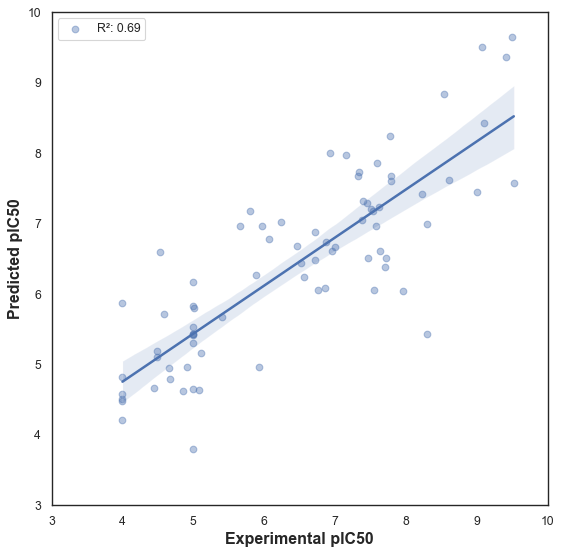

In [16]:
# Let’s check the difference between the actual and predicted values.
df=pd.DataFrame({'Actual':Y_test, 'Predicted':Y_pred})

sns.set(color_codes=True)
sns.set_style("white")

fig, ax = plt.subplots(figsize = (8, 8), dpi  = 80)
ax = sns.regplot(x=Y_test,y=Y_pred, scatter_kws={'alpha':0.4}, label = f"R²: {metrics.r2_score(Y_test, Y_pred).round(2)}")
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim((3, 10))
ax.set_ylim((3, 10))
ax.legend()
plt.show

## 4) Predict pIC50 of the simlarity database molecules

We load the database of similarity-filtered molecule we generated in the previous assignment. We obtain their fingerprints and use the trained model to predict their pIC50.

In [17]:
similarity = pd.read_csv("./final_similarity_Vemurafenib_85%.csv", sep=',', header = 0)
similarity

,CanonicalSMILES,CID,ROMol,tanimoto_maccs,dice_maccs,tanimoto_morgan,dice_morgan
0,C.C.C.C.CCCS(=O)(=O)NC1=CC=CC(=C1F)C(=O)C2=CNC...,159417127,<rdkit.Chem.rdchem.Mol object at 0x00000192368...,0.918919,0.957746,0.550000,0.709677
1,C.CCCS(=O)(=O)NC1=C(C(=C(C=C1)Cl)C(=O)C2=CNC3=...,157249382,<rdkit.Chem.rdchem.Mol object at 0x00000192368...,0.957746,0.978417,0.605634,0.754386
2,C.CCCS(=O)(=O)NC1=C(C(=C(C=C1)F)C(=O)C2=CNC3=C...,160643258,<rdkit.Chem.rdchem.Mol object at 0x00000192368...,0.971831,0.985714,0.983333,0.991597
3,C1=CC(=C(C(=C1C(=O)C2=CNC3=C2C=C(C=N3)C4=CN=C(...,146302457,<rdkit.Chem.rdchem.Mol object at 0x00000192368...,0.928571,0.962963,0.487500,0.655462
4,C1=CC(=C(C(=C1NS(=O)(=O)CCC(F)(F)F)F)C(=O)C2=C...,87088899,<rdkit.Chem.rdchem.Mol object at 0x00000192368...,0.914286,0.955224,0.611111,0.758621
...,...,...,...,...,...,...,...
677,CCS(=O)(=O)NC1=C(C(=C(C=C1)F)C(=O)CC2=CN=C3C(=...,58251969,<rdkit.Chem.rdchem.Mol object at 0x00000192367...,0.913043,0.954545,0.397590,0.568966
678,CCS(=O)(=O)NC1=C(C=CC(=C1F)C(=O)C2=CNC3=C2C=C(...,164938927,<rdkit.Chem.rdchem.Mol object at 0x00000192367...,0.927536,0.962406,0.540541,0.701754
679,CCS(=O)(=O)NC1=C(C=CC(=C1F)C(=O)C2=CNC3=C2C=C(...,164938923,<rdkit.Chem.rdchem.Mol object at 0x00000192367...,0.915493,0.955882,0.493671,0.661017
680,[B]C1=CC2=C(NC=C2C(=O)C3=C(C=CC(=C3F)NS(=O)(=O...,88917998,<rdkit.Chem.rdchem.Mol object at 0x00000192367...,0.943662,0.971014,0.753846,0.859649


In [18]:
# Obtain the fingerprints
similarity["MACCS_fp"] = similarity["CanonicalSMILES"].apply(smiles_to_fp)
similarity[["CID", "CanonicalSMILES", "MACCS_fp"]].head()

[11:36:46] WARNING: not removing hydrogen atom without neighbors
[11:36:46] WARNING: not removing hydrogen atom without neighbors


,CID,CanonicalSMILES,MACCS_fp
0,159417127,C.C.C.C.CCCS(=O)(=O)NC1=CC=CC(=C1F)C(=O)C2=CNC...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,157249382,C.CCCS(=O)(=O)NC1=C(C(=C(C=C1)Cl)C(=O)C2=CNC3=...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,160643258,C.CCCS(=O)(=O)NC1=C(C(=C(C=C1)F)C(=O)C2=CNC3=C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,146302457,C1=CC(=C(C(=C1C(=O)C2=CNC3=C2C=C(C=N3)C4=CN=C(...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,87088899,C1=CC(=C(C(=C1NS(=O)(=O)CCC(F)(F)F)F)C(=O)C2=C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [19]:
# Create a list with the fingerprint bits and transform it into a new dataframe
fingerprints = similarity['MACCS_fp'].to_numpy().tolist()
fingerprint_df = pd.DataFrame(fingerprints)
fingerprint_df

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,0
678,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,0
679,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,0
680,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,0


In [20]:
# Predict the pIC50 values for the new database's fingerprints
pred = rfr.predict(fingerprint_df) 

# Transform the predictions into a Dataframe and append them to the Similarity database
similarity["pIC50_pred"] = pd.DataFrame({"pIC50_pred":pred})
similarity[["CID", "CanonicalSMILES", "MACCS_fp", "pIC50_pred"]].head()

,CID,CanonicalSMILES,MACCS_fp,pIC50_pred
0,159417127,C.C.C.C.CCCS(=O)(=O)NC1=CC=CC(=C1F)C(=O)C2=CNC...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.403003
1,157249382,C.CCCS(=O)(=O)NC1=C(C(=C(C=C1)Cl)C(=O)C2=CNC3=...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.414655
2,160643258,C.CCCS(=O)(=O)NC1=C(C(=C(C=C1)F)C(=O)C2=CNC3=C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.139311
3,146302457,C1=CC(=C(C(=C1C(=O)C2=CNC3=C2C=C(C=N3)C4=CN=C(...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.338560
4,87088899,C1=CC(=C(C(=C1NS(=O)(=O)CCC(F)(F)F)F)C(=O)C2=C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.410358


Last, we will convert back the activity measures into IC50 to compare and filter our molecules in a more precise way.

In [21]:
# Convert back pIC50 values to IC50 and append them to the Similarity database
similarity["IC50_pred"] = similarity.apply(lambda x: convert_ic50_to_pic50(pIC50 = x.pIC50_pred, reverse = True), axis=1)

# Sort molecules accroding to their predicted IC50 value
similarity = similarity.sort_values(by = "IC50_pred", axis=0).reset_index(drop = 0)      # IC50 is already a float
similarity[["CID", "CanonicalSMILES", "MACCS_fp", "pIC50_pred", "IC50_pred"]]


,CID,CanonicalSMILES,MACCS_fp,pIC50_pred,IC50_pred
0,59506884,CCCS(=O)(=O)NC1=C(C(=C(C=C1)F)C(C)C2=CNC3=C2C=...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7.023214,94.795108
1,66870822,CCCS(=O)(=O)NC1=C(C(=C(C=C1)F)CC2=CNC3=C2C=C(C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7.023105,94.818945
2,58251983,CCCS(=O)(=O)NC1=C(C(=C(C=C1)F)C(=O)CC2=CC3=C(N...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.987114,103.011530
3,143384592,CCC[S+](=O)(NC1=C(C(=C(C=C1)F)C(=O)C2=CNC3=C2C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.950320,112.119208
4,58087463,CCCS(=O)(=O)NC1=C(C(=C(C=C1)F)C(=O)C2=CNC3=C2C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.897704,126.559967
...,...,...,...,...,...
677,132099655,CCCS(=O)(=O)NC1=CC=CC(=C1)C(=O)C2=CNC3=C2C=C(C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4.776476,16731.075766
678,135248758,CCCS(=O)(=O)NC1=CC(=CC(=C1)C(=O)C2=CNC3=C2C=C(...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4.762902,17262.274334
679,58086157,CCCS(=O)(=O)NC1=CC=CC(=C1)C(=O)C2=CNC3=C2C=C(C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4.688528,20486.713801
680,66646981,CCCCS(=O)(=O)NC1=CC=CC(=C1)C(=O)C2=CNC3=C2C=C(...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4.636241,23107.827558


The predicted IC50 values for the molecules in our similarity database range from 0.08 nM to 13 µM, therefore, none of them has a higher predicted activity than our query molecule (0.02 nM). We fixed a threshold of IC50 < 175 nM to select at least 15 molecules with the highest inhibitory activity. 

In [40]:
# Filter the molecules from our similarity database based on their predicted IC50 values.
qsar_final_database = similarity[similarity.IC50_pred < 180]
print("Number of filtered molecules:", len(qsar_final_database), "\n")
qsar_final_database[["CID", "CanonicalSMILES", "MACCS_fp", "pIC50_pred", "IC50_pred"]]

Number of filtered molecules: 45 



,CID,CanonicalSMILES,MACCS_fp,pIC50_pred,IC50_pred
0,59506884,CCCS(=O)(=O)NC1=C(C(=C(C=C1)F)C(C)C2=CNC3=C2C=...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7.023214,94.795108
1,66870822,CCCS(=O)(=O)NC1=C(C(=C(C=C1)F)CC2=CNC3=C2C=C(C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7.023105,94.818945
2,58251983,CCCS(=O)(=O)NC1=C(C(=C(C=C1)F)C(=O)CC2=CC3=C(N...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.987114,103.011530
3,143384592,CCC[S+](=O)(NC1=C(C(=C(C=C1)F)C(=O)C2=CNC3=C2C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.950320,112.119208
4,58087463,CCCS(=O)(=O)NC1=C(C(=C(C=C1)F)C(=O)C2=CNC3=C2C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.897704,126.559967
5,58087390,CCCS(=O)(=O)NC1=C(C(=C(C=C1)F)C(=O)C2=CNC3=C2C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.895076,127.328152
6,58086030,CCCS(=O)(=O)NC1=C(C(=C(C=C1)F)CC2=CNC3=C2C=C(C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.892161,128.185500
7,153376300,CCCS(=O)NC1=C(C(=C(C=C1)F)C(=O)C2=CC3=C(C=C2)N...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.861587,137.535031
8,66646723,CCCS(=O)(=O)NC1=CC(=C(C=C1)F)C(=O)C2=CNC3=C2C=...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.854930,139.659428
9,53262272,CCCS(=O)(=O)NC1=C(C(=C(C=C1)F)C(=O)C2=CNC3=C2C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.854930,139.659428


We save our filtered data in a new csv file for further analysis.

In [41]:
qsar_final_database.to_csv("./qsar_vemuraf_database.csv", header = True, index = False)

# Ensuring ADMET properties

Before we continue with the Structure-Based Virtual Screening of our similarity database, we want to ensure that our molecules fulfill the Lipinski's Rule of Five criteria. These rules evaluate druglikeness of chemical compounds based on specific chemical and physical properties important for a drug's pharmacokinetics in the human body (Adsortion, Distribution, Metabolism, Elimination and Toxicity). 


In [42]:
def calculate_ro5_properties(smiles):
    """
    Test if input molecule (SMILES) fulfills Lipinski's rule of five.

    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Calculate Ro5-relevant chemical properties
    molecular_weight = Descriptors.ExactMolWt(molecule)
    n_hba = Descriptors.NumHAcceptors(molecule)
    n_hbd = Descriptors.NumHDonors(molecule)
    logp = Descriptors.MolLogP(molecule)
    TPSA = Descriptors.TPSA (molecule)
    # Check if Ro5 conditions fulfilled
    conditions = [molecular_weight <= 500, n_hba <= 10, n_hbd <= 5, logp <= 5, TPSA < 140]
    ro5_fulfilled = sum(conditions) > 4
    # Return True if no more than one out of four conditions is violated
    return pd.Series(
        [molecular_weight, n_hba, n_hbd, logp, TPSA, ro5_fulfilled],
        index=['molecular_weight', 'n_hba', 'n_hbd', 'logp', 'TPSA', 'ro5_fulfilled'],
    )

In [43]:
# Test Ro5 function on our database
ro5_properties = qsar_final_database['CanonicalSMILES'].apply(calculate_ro5_properties)
print("Number of molecules fulfilling Ro5:", len(ro5_properties[ro5_properties.ro5_fulfilled == True]), "\n")
ro5_properties

Number of molecules fulfilling Ro5: 33 



,molecular_weight,n_hba,n_hbd,logp,TPSA,ro5_fulfilled
0,489.108932,3,2,6.46500,74.85,False
1,475.093282,3,2,5.90400,74.85,False
2,533.098761,5,3,5.15330,112.15,False
3,490.079823,3,3,6.10190,95.08,False
4,451.101348,5,3,3.24100,129.22,True
5,449.085698,5,3,3.32160,129.22,True
6,399.061982,3,2,4.23700,74.85,True
7,507.122833,3,2,6.51700,74.85,False
8,441.127089,6,2,3.48520,109.74,True
9,459.117667,6,2,3.62430,109.74,True


As we can see, just 33 drug candidates fulfill the Rule of Five (Ro5). Therefore, we append the Ro5 fulfillment status in a new column to our QSAR-filtered molecule database and we save filtered molecules into a new csv file.

In [59]:
# Add the results to our database and filter molecules that fulfill Ro5
qsar_ro5_database = pd.concat([qsar_final_database, ro5_properties], axis = 1).drop("index", axis=1)
qsar_ro5_final_database = qsar_ro5_database[qsar_ro5_database.ro5_fulfilled == True].reset_index(drop=True)
qsar_ro5_final_database.head()

,CanonicalSMILES,CID,ROMol,tanimoto_maccs,dice_maccs,tanimoto_morgan,dice_morgan,MACCS_fp,pIC50_pred,IC50_pred,molecular_weight,n_hba,n_hbd,logp,TPSA,ro5_fulfilled
0,CCCS(=O)(=O)NC1=C(C(=C(C=C1)F)C(=O)C2=CNC3=C2C...,58087463,<rdkit.Chem.rdchem.Mol object at 0x00000192367...,0.917808,0.957143,0.700000,0.823529,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.897704,126.559967,451.101348,5,3,3.2410,129.22,True
1,CCCS(=O)(=O)NC1=C(C(=C(C=C1)F)C(=O)C2=CNC3=C2C...,58087390,<rdkit.Chem.rdchem.Mol object at 0x00000192367...,0.905405,0.950355,0.700000,0.823529,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.895076,127.328152,449.085698,5,3,3.3216,129.22,True
2,CCCS(=O)(=O)NC1=C(C(=C(C=C1)F)CC2=CNC3=C2C=C(C...,58086030,<rdkit.Chem.rdchem.Mol object at 0x00000192367...,0.914286,0.955224,0.541667,0.702703,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.892161,128.185500,399.061982,3,2,4.2370,74.85,True
3,CCCS(=O)(=O)NC1=CC(=C(C=C1)F)C(=O)C2=CNC3=C2C=...,66646723,<rdkit.Chem.rdchem.Mol object at 0x00000192367...,0.906667,0.951049,0.558442,0.716667,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.854930,139.659428,441.127089,6,2,3.4852,109.74,True
4,CCCS(=O)(=O)NC1=C(C(=C(C=C1)F)C(=O)C2=CNC3=C2C...,53262272,<rdkit.Chem.rdchem.Mol object at 0x00000192367...,0.906667,0.951049,0.742857,0.852459,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.854930,139.659428,459.117667,6,2,3.6243,109.74,True


In [61]:
qsar_ro5_final_database.to_csv("./qsar_ro5_vemuraf_database.csv", header = True, index = False)

# Plotting ADMET properties.

Finally we plot the mean and standard deviation values of the ADMET properties. This shows some properties of our database, such as how different the molecules are or which properties are closer to be unfulfilled. 

In [62]:
def calculate_mean_std(dataframe):
    """
    Calculate the mean and standard deviation of a dataset.

    """
    # Generate descriptive statistics for property columns
    stats = dataframe.describe()
    # Transpose DataFrame (statistical measures = columns)
    stats = stats.T
    # Select mean and standard deviation
    stats = stats[['mean', 'std']]
    return stats

In [63]:
def _scale_by_thresholds(stats, thresholds, scaled_threshold):
    """
    Scale values for different properties that have each an individually defined threshold.

    Parameters
    ----------
    stats : pd.DataFrame
        Dataframe with "mean" and "std" (columns) for each physicochemical property (rows).
    thresholds : dict of str: int
        Thresholds defined for each property.
    scaled_threshold : int or float
        Scaled thresholds across all properties.

    Returns
    -------
    pd.DataFrame
        DataFrame with scaled means and standard deviations for each physiochemical property.
    """
    # Raise error if scaling keys and data_stats indicies are not matching
    for property_name in stats.index:
        if property_name not in thresholds.keys():
            raise KeyError(f"Add property '{property_name}' to scaling variable.")
    # Scale property data
    stats_scaled = stats.apply(lambda x: x / thresholds[x.name] * scaled_threshold, axis=1)
    return stats_scaled

In [64]:
def _define_radial_axes_angles(n_axes):
    """Define angles (radians) for radial (x-)axes depending on the number of axes."""
    x_angles = [i / float(n_axes) * 2 * math.pi for i in range(n_axes)]
    x_angles += x_angles[:1]
    return x_angles

In [65]:
def plot_radar(
    y,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max=None,
    output_path=None,
):
    """
    Plot a radar chart based on the mean and standard deviation of a data set's properties.

    Parameters
    ----------
    y : pd.DataFrame
        Dataframe with "mean" and "std" (columns) for each physicochemical property (rows).
    thresholds : dict of str: int
        Thresholds defined for each property.
    scaled_threshold : int or float
        Scaled thresholds across all properties.
    properties_labels : list of str
        List of property names to be used as labels in the plot.
    y_max : None or int or float
        Set maximum y value. If None, let matplotlib decide.
    output_path : None or pathlib.Path
        If not None, save plot to file.
    """

    # Define radial x-axes angles -- uses our helper function!
    x = _define_radial_axes_angles(len(y))
    # Scale y-axis values with respect to a defined threshold -- uses our helper function!
    y = _scale_by_thresholds(y, thresholds, scaled_threshold)
    # Since our chart will be circular we append the first value of each property to the end
    y = y.append(y.iloc[0])

    # Set figure and subplot axis
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)

    # Plot data
    ax.fill(x, [scaled_threshold] * 6, "cornflowerblue", alpha=0.2)
    ax.plot(x, y["mean"], "b", lw=3, ls="-")
    ax.plot(x, y["mean"] + y["std"], "orange", lw=2, ls="--")
    ax.plot(x, y["mean"] - y["std"], "orange", lw=2, ls="-.")

    # From here on, we only do plot cosmetics
    # Set 0° to 12 o'clock
    ax.set_theta_offset(math.pi / 2)
    # Set clockwise rotation
    ax.set_theta_direction(-1)

    # Set y-labels next to 180° radius axis
    ax.set_rlabel_position(180)
    # Set number of radial axes' ticks and remove labels
    plt.xticks(x, [])
    # Get maximal y-ticks value
    if not y_max:
        y_max = int(ax.get_yticks()[-1])
    # Set axes limits
    plt.ylim(0, y_max)
    # Set number and labels of y axis ticks
    plt.yticks(
        range(1, y_max),
        ["5" if i == scaled_threshold else "" for i in range(1, y_max)],
        fontsize=16,
    )

    # Draw ytick labels to make sure they fit properly
    # Note that we use [:1] to exclude the last element which equals the first element (not needed here)
    for i, (angle, label) in enumerate(zip(x[:-1], properties_labels)):
        if angle == 0:
            ha = "center"
        elif 0 < angle < math.pi:
            ha = "left"
        elif angle == math.pi:
            ha = "center"
        else:
            ha = "right"
        ax.text(
            x=angle,
            y=y_max + 1,
            s=label,
            size=16,
            horizontalalignment=ha,
            verticalalignment="center",
        )

    # Add legend relative to top-left plot
    labels = ("mean", "mean + std", "mean - std", "rule of five area")
    ax.legend(labels, loc=(1.1, 0.7), labelspacing=0.3, fontsize=16)

    # Save plot - use bbox_inches to include text boxes
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches="tight", transparent=True)

    plt.show()

In [69]:
# Calculating means and standard deviation
qsar_ro5_database_stats = calculate_mean_std(
    qsar_ro5_database[['molecular_weight', 'n_hba', 'n_hbd', 'logp', 'TPSA']]
)
qsar_ro5_database_stats


,mean,std
molecular_weight,464.313406,62.115274
n_hba,4.444444,0.918387
n_hbd,2.222222,0.517375
logp,4.326235,0.919655
TPSA,101.952222,20.639912


C:\Users\adrib\AppData\Local\Temp\ipykernel_30588\332170837.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y = y.append(y.iloc[0])


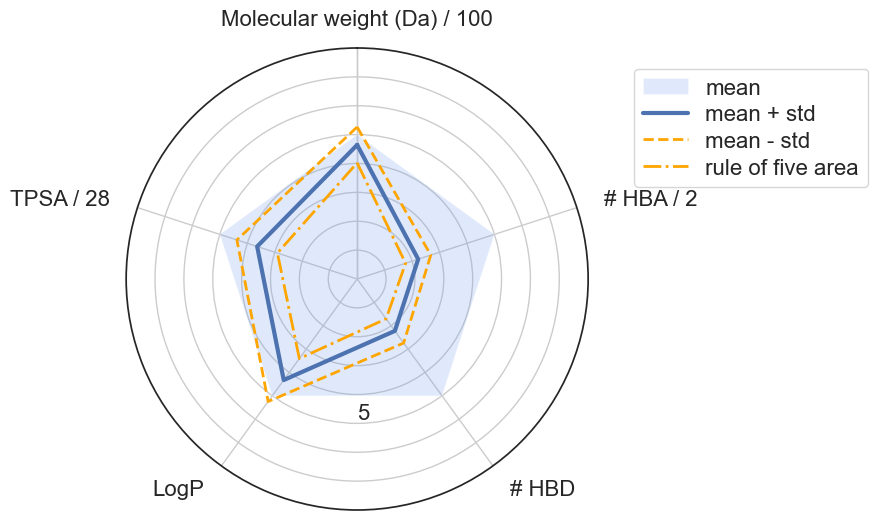

In [70]:
# Asjusting graph parameters and plotting
thresholds = {"molecular_weight": 500, "n_hba": 10, "n_hbd": 5, "logp": 5, "TPSA":140}
scaled_threshold = 5
properties_labels = [
    "Molecular weight (Da) / 100",
    "# HBA / 2",
    "# HBD",
    "LogP",
    "TPSA / 28"
]
y_max = 8

plot_radar(
    qsar_ro5_database_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max,
)

Here, we can see that some of the molecules exceed the area of accepted values under the rule of five, the more “dangerous” values (i.e. those that cause an exclusion) are molecular weight and n-octanol-water partition coefficient (here specified as LogP in log scale). Moreover, since our final database is composed by very simiar molecules, the standard deviation range is really short.
